In [1]:
!pip install staintools
!pip install spams

  Preparing metadata (setup.py) ... done
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14051 sha256=b816513ec1a40661324a5ecee0a8384f903390f30ce7a544842bb30be99181df
  Stored in directory: /Users/alexandrasmith/Library/Caches/pip/wheels/26/76/44/7b56abaf5d8fedb42a76bece5757d39bc299bb29006475313c
Successfully built staintools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.0 MB/s eta 0:00:0000:0100:01m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for spams: filename=spams-2.6.5.4-cp38-cp38-macosx_12_0_arm64.whl size=969519 sha256=b125b0a2098cdac909d085551621f3748f9f1bd7bca0501189644c69c028fcd0
  Stored in directory: /Users/alexandrasmith/Library/Caches/pip/wheels/8c/a4/c3/04404cb133db3e4feb385ff71f599c52f2ec8a53e2bd789a46
Successfully built spams


In [12]:
import functools
import torch.nn as nn
from torchvision.models import squeezenet1_1


class SqueezeNet(nn.Module):
    def __init__(self, n_class=2):
        super(SqueezeNet, self).__init__()
        self.n_class = n_class
        self.base_model = squeezenet1_1(pretrained=True)
        temp = squeezenet1_1(pretrained=False, num_classes=n_class)
        self.base_model.classifier = temp.classifier
        del temp

    def forward(self, x):
        return self.base_model(x)


class StainNet(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, n_layer=3, n_channel=32, kernel_size=1):
        super(StainNet, self).__init__()
        model_list = []
        model_list.append(nn.Conv2d(input_nc, n_channel, kernel_size=kernel_size, bias=True, padding=kernel_size // 2))
        model_list.append(nn.ReLU(True))
        for n in range(n_layer - 2):
            model_list.append(
                nn.Conv2d(n_channel, n_channel, kernel_size=kernel_size, bias=True, padding=kernel_size // 2))
            model_list.append(nn.ReLU(True))
        model_list.append(nn.Conv2d(n_channel, output_nc, kernel_size=kernel_size, bias=True, padding=kernel_size // 2))

        self.rgb_trans = nn.Sequential(*model_list)

    def forward(self, x):
        return self.rgb_trans(x)


class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.
    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6,
                 padding_type='reflect'):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert (n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):  # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout,
                                  use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

### Imports

In [4]:
import sys
import os
import staintools

import torch
import numpy as np
import matplotlib.pyplot as plt  
import matplotlib.pyplot as plt

In [5]:
sys.path.append('../input/StainNet/')

### Helper functions

In [13]:
# https://github.com/khtao/StainNet/blob/master/demo.ipynb
def norm(image):
    image = np.array(image).astype(np.float32)
    image = image.transpose((2, 0, 1))
    image = ((image / 255) - 0.5) / 0.5
    image=image[np.newaxis, ...]
    image=torch.from_numpy(image)
    return image

def un_norm(image):
    image = image.cpu().detach().numpy()[0]
    image = ((image * 0.5 + 0.5) * 255).astype(np.uint8).transpose((1,2,0))
    return image

def highlight(row):
    df = lambda x: ['background: #CCCCFF' if x.name in row
                        else '' for i in x]
    return df

### Get images

In [14]:
PATCH_DIR='/Volumes/AlexS/MastersData/processed/patches/'
patches = os.listdir(PATCH_DIR)

In [42]:
source = torch.load(PATCH_DIR + patches[0])[0, :, :, :]
target = torch.load(PATCH_DIR + patches[1])[15, :, :, :]

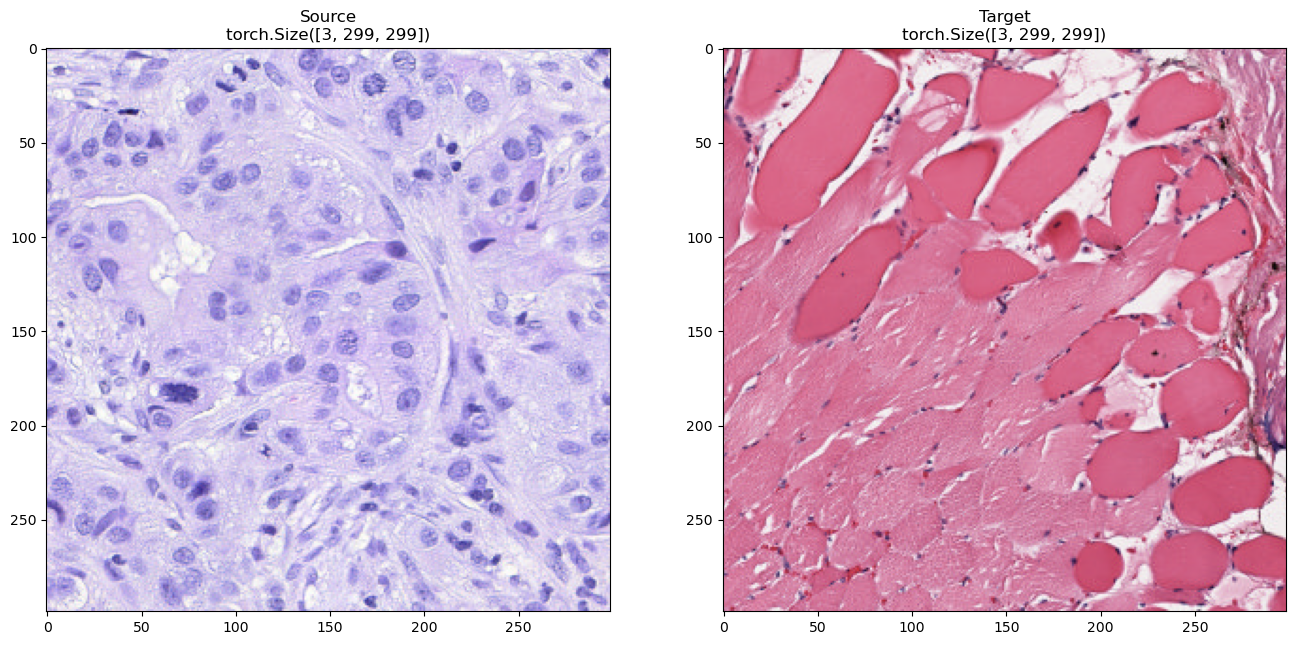

In [43]:
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.title(f"Source\n{source.shape}")
plt.imshow(np.transpose(source.numpy(), (1, 2, 0)))
plt.subplot(122)
plt.title(f'Target\n{target.shape}')
plt.imshow(np.transpose(target.numpy(), (1, 2, 0)))

### Vahadane

### StainGAN

In [44]:
# load pretrained StainGAN
model_GAN = ResnetGenerator(3, 3, ngf=64, norm_layer=torch.nn.InstanceNorm2d, n_blocks=9)
model_GAN.load_state_dict(torch.load('latest_net_G_A.pth'))

<All keys matched successfully>

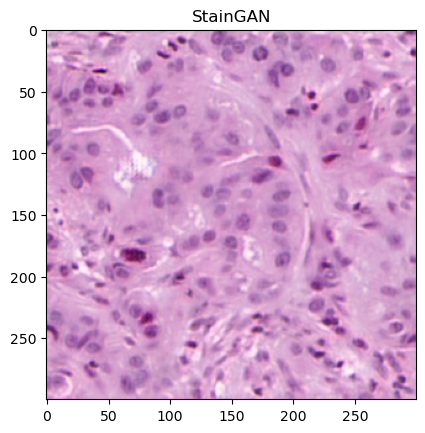

In [63]:
model_GAN.eval()
with torch.no_grad():
    img_gan = model_GAN(norm(np.transpose(source.numpy(), (1, 2, 0))))
    img_gan = un_norm(img_gan)
    plt.imshow(img_gan)
    plt.title('StainGAN')

### StainNet

In [39]:
print(torch.version.cuda)

None


In [40]:
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu111/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.html


In [41]:
print(torch.version.cuda)

None


In [33]:
# load  pretrained StainNet
model_Net = StainNet()
model_Net.load_state_dict(torch.load("StainNet-Public_layer3_ch32.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

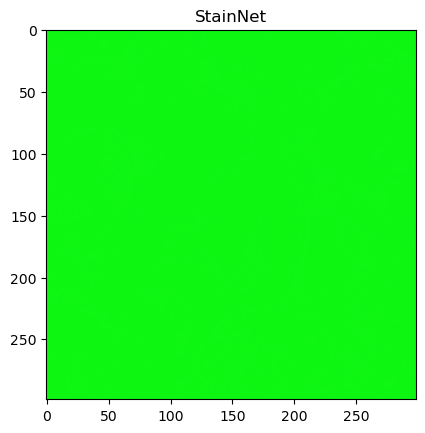

In [38]:
model_Net.eval()
with torch.no_grad():
    img_net=model_Net(norm(np.transpose(source.numpy(), (1, 2, 0))))
    img_net=un_norm(img_net)
    plt.imshow(img_net)
    plt.title('StainNet')